# Feature Analysis Notebook

**Related to Figure 4, Figure 5, and Supplemental Figure 2**  

Figures Generated:
- Figure 4A
- Figure 4B
- Figure 4C
- Figure 4D
- Figure 4E
- Figure 4F
- SFig 2C
- Figure 5A
- Figure 5B
- Figure 5D

Tables Generated:
- Table 1

### Set Up

In [147]:
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from statsmodels.stats.multitest import fdrcorrection
import sklearn.preprocessing as prep
import statsmodels.api as sm

import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr
from sklearn import linear_model
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.linear_model import ElasticNet

In [69]:
cwd= os.getcwd()

In [70]:
datadir = os.path.join(cwd, '..')

In [71]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.5
import matplotlib.font_manager as fm
arial_font_path = os.path.join(datadir, 'Reference_Data', 'Arial.TTF')
fm.fontManager.addfont(arial_font_path)
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
blue='#6ec1e0'
green='#5fad56'
shared='#af3800'
binary='#00606f'
purple='#441f5d'
raspberry='#b4436c'

In [126]:
feature_names={
    'N_C': 'Study Size - Common',
    'N_R': "Study Size - Rare",
    'assortativity_RC':'Assortativity',
    'g_C': 'Number of Genes - Common',
    'g_R': 'Number of Genes - Rare',
    'J_RC': 'Jaccard Sim.',
    'density_R': 'Subnetwork Density - Rare',
    'density_C': 'Subnetwork Density - Common',
    'binary': 'Is Trait Binary',
    'jaccard_zero': 'No shared genes', 
    'Mean_LOEUF': 'Mean LOEUF', 
    'DiffRC_LOEUF':'Diff. LOEUF', 
    'Mean_GeneSize':'Mean Gene Size', 
    'DiffRC_GeneSize':'Diff. Gene Size',
    'Mean_GO': 'Mean GO Terms', 
    'DiffRC_GO': 'Diff. GO Terms', 
    'Mean_mRNA': 'Mean Exp.', 
    'DiffRC_mRNA': 'Diff. Exp.', 
    'Mean_nTissues': 'Mean Exp. Tissues',
    'DiffRC_nTissues': 'Diff. Exp. Tissues'}

### Load Data

In [74]:
all_feat = pd.read_csv(os.path.join(datadir, 'outputs/STable4.tsv'), sep='\t')
all_feat.columns

Index(['EFO', 'Common Study', 'Rare Study', 'log2COLOC', 'N_C', 'N_R',
       'binary', 'g_C', 'g_R', 'J_RC', 'jaccard_zero', 'density_C',
       'density_R', 'assortativity_RC', 'Mean_LOEUF', 'DiffRC_LOEUF',
       'Mean_GeneSize', 'DiffRC_GeneSize', 'Mean_GO', 'DiffRC_GO', 'Mean_mRNA',
       'DiffRC_mRNA', 'Mean_nTissues', 'DiffRC_nTissues'],
      dtype='object')

In [105]:
h2_prev = pd.read_csv(os.path.join(datadir, 'outputs/STable3.tsv'), sep='\t')
prev_df = h2_prev.dropna(subset='5 Year Prevalence').drop(columns=['SNP-Heritability'])
h2_df = h2_prev.dropna(subset='SNP-Heritability').drop(columns=['5 Year Prevalence'])

In [107]:
def get_trait_pair(df):
    df['trait_pair'] = df['Rare Study'].astype(int).astype(str) + '_' + df['EFO'] +'_' +df['Common Study'] +'_'+ df['EFO']
    return df

In [189]:
coloc_df = pd.read_csv(os.path.join(datadir, 'outputs/STable2.tsv'), sep='\t')
coloc_df = get_trait_pair(coloc_df)
best_df = coloc_df[coloc_df['Optimal COLOC']].copy()

In [109]:
all_feat = all_feat.dropna()

In [110]:
all_feat = get_trait_pair(all_feat)

## Heritability and Prevalence Analysis

In [111]:
all_feat2 = all_feat.copy()
all_feat_h2 = h2_df.merge(all_feat2, on=['EFO'], how='left')
all_feat_prev = prev_df.merge(all_feat2, on='EFO', how='left')

In [112]:
all_feat_h2 = all_feat_h2[all_feat_h2.trait_pair.isin(best_df.trait_pair.values)]
all_feat_prev = all_feat_prev[all_feat_prev.trait_pair.isin(best_df.trait_pair.values)]

### Figure 4A - Heritability

In [113]:
all_feat_h2.head()

,EFO,SNP-Heritability,Common Study,Rare Study,log2COLOC,N_C,N_R,binary,g_C,g_R,...,DiffRC_LOEUF,Mean_GeneSize,DiffRC_GeneSize,Mean_GO,DiffRC_GO,Mean_mRNA,DiffRC_mRNA,Mean_nTissues,DiffRC_nTissues,trait_pair
1,EFO_0000095,0.001883,GCST002073,34662886,1.063676,8400.0,387925.259259,1,9,4,...,1.033334,99158.230769,-0.848344,42.153846,0.434783,14.185238,1.348675,44.307692,0.297872,34662886_EFO_0000095_GCST002073_EFO_0000095
5,EFO_0000198,0.000180,GCST009516,34375979,-0.438852,6512.0,206382.000000,1,5,14,...,-0.058063,124104.368421,-1.290406,17.789474,-0.162162,12.769770,0.922523,51.368421,0.204082,34375979_EFO_0000198_GCST009516_EFO_0000198
6,EFO_0000217,0.001084,GCST002638,34375979,-0.147295,8738.0,260313.000000,1,4,23,...,-0.676029,70957.481481,-1.247023,12.000000,0.000000,9.787635,-1.019747,49.740741,0.181818,34375979_EFO_0000217_GCST002638_EFO_0000217
11,EFO_0000275,0.003725,GCST90204201,34375979,0.856803,2339188.0,281104.000000,1,86,9,...,0.091920,149922.147368,-0.974021,14.810526,-0.142857,10.271961,0.013567,51.147368,-0.189474,34375979_EFO_0000275_GCST90204201_EFO_0000275
13,EFO_0000280,0.003527,GCST003738,34375979,-0.477396,23326.0,197822.000000,1,4,12,...,-0.004810,99664.625000,-1.262652,10.250000,-0.583333,7.974620,0.024201,46.000000,0.088889,34375979_EFO_0000280_GCST003738_EFO_0000280


In [114]:
all_feat_h2.loc[:, ('log2COLOC', 'SNP-Heritability')].corr(method='spearman')
r_h2 = all_feat_h2.loc[:, ('log2COLOC', 'SNP-Heritability')].corr(method='spearman').at['log2COLOC', 'SNP-Heritability']


In [115]:
all_feat_h2.shape

(197, 26)

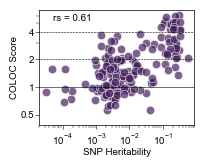

In [116]:
_ = plt.figure(figsize=(2,1.5))
sns.scatterplot(all_feat_h2, y='log2COLOC', x='SNP-Heritability', alpha=0.7, color=purple)
plt.hlines(y=0, xmin=-0.05, xmax=0.9, color='black', linewidth=0.4)
plt.hlines(y=[1, 2], xmin=-0.05, xmax=0.9, color='black', linewidth=0.4, linestyle='--')
plt.xlim(0.00002, 0.9)
ax1 = plt.gca()
ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
_ =ax1.set_ylabel('COLOC Score')
_ =ax1.set_xlabel('SNP Heritability')
_ = plt.text(x=0.00005, y=2.4, s=f'rs = {r_h2:.2f}')
plt.xscale('log')
#plt.savefig(os.path.join(figdir, 'heritability_scatter.svg'), bbox_inches='tight')

### Figure 4B - Prevalence

In [117]:
all_feat_prev.loc[:, ('log2COLOC','5 Year Prevalence', 'g_C', 'g_R')].corr(method='spearman')
r_prev = all_feat_prev.loc[:, ('log2COLOC','5 Year Prevalence')].corr(method='spearman').at['log2COLOC', '5 Year Prevalence']
all_feat_prev.shape

(87, 26)

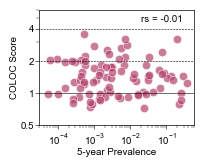

In [118]:
_ = plt.figure(figsize=(2,1.5))
sns.scatterplot(all_feat_prev, y='log2COLOC', x='5 Year Prevalence', alpha=0.7, color=raspberry)
plt.hlines(y=0, xmin=-0.05, xmax=0.6, color='black', linewidth=0.4)
plt.hlines(y=[1, 2], xmin=-0.05, xmax=0.6, color='black', linewidth=0.4, linestyle='--')
plt.xlim(.00003, 0.6)
ax1 = plt.gca()
ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
_ =ax1.set_ylabel('COLOC Score')
_ =ax1.set_xlabel('5-year Prevalence')
_ = plt.text(x=0.02, y=2.2, s=f'rs = {r_prev:.2f}')
plt.xscale('log')
#plt.savefig(os.path.join(figdir, 'prevalence_scatter.svg'), bbox_inches='tight')

### Figure 4C - Heritability Correlations

In [123]:
all_feat_h2.columns

Index(['EFO', 'SNP-Heritability', 'Common Study', 'Rare Study', 'log2COLOC',
       'N_C', 'N_R', 'binary', 'g_C', 'g_R', 'J_RC', 'jaccard_zero',
       'density_C', 'density_R', 'assortativity_RC', 'Mean_LOEUF',
       'DiffRC_LOEUF', 'Mean_GeneSize', 'DiffRC_GeneSize', 'Mean_GO',
       'DiffRC_GO', 'Mean_mRNA', 'DiffRC_mRNA', 'Mean_nTissues',
       'DiffRC_nTissues', 'trait_pair'],
      dtype='object')

In [127]:
h2_corrs = {}
for prop in ['J_RC', 'assortativity_RC', 'density_R', 'g_C', 'DiffRC_GeneSize', 
            'N_R', 'Mean_GO', 'DiffRC_GO', 'N_C', 'DiffRC_LOEUF', 'g_R', 'density_C', 'Mean_nTissues',
            'Mean_mRNA', 'Mean_LOEUF', 'DiffRC_mRNA', 'Mean_GeneSize', 'DiffRC_nTissues']:
    h2_corrs[prop] = {}
    h2_corrs[prop]['r'] = spearmanr(all_feat_h2['SNP-Heritability'], all_feat_h2[prop]).statistic
    h2_corrs[prop]['p'] = spearmanr(all_feat_h2['SNP-Heritability'], all_feat_h2[prop]).pvalue
h2_corrs = pd.DataFrame(h2_corrs).T
h2_corrs['q'] = fdrcorrection(h2_corrs.p.values)[1]
h2_corrs['logq'] = h2_corrs.q.apply(lambda x: 'n.s' if x >0.05 else 'q < 0.05' if x > 0.0001 else 'q < 10-4' if x > 0.00000001 else 'q < 10-8')
h2_corrs['Property'] = h2_corrs.index.map(feature_names)

Text(0.5, 0, 'SNP Heritability\nSpearman Correlation')

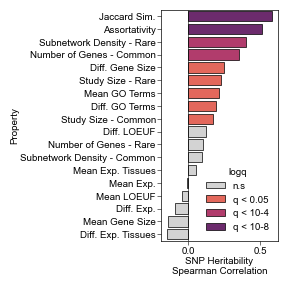

In [130]:
_ = plt.figure(figsize=(1.5,3))
sns.barplot(h2_corrs, y='Property', x='r',  hue='logq', edgecolor='black', saturation=1, 
            palette=['lightgrey', '#e3685c', '#b13c6c', '#6c2b6d'], 
            hue_order = ['n.s', 'q < 0.05', 'q < 10-4', 'q < 10-8'])
plt.vlines(x=0, ymin=-0.5, ymax=17.5, color='black', linewidth=0.4)
plt.ylim(17.5, -0.5)
plt.xlabel('SNP Heritability\nSpearman Correlation')
#plt.savefig(os.path.join(figdir, 'H2_correlations.svg'), bbox_inches='tight')

## Regression Analysis

### Normalization & Scaling

In [131]:
def compare_transforms(input_df, col, log=False):
    _, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(nrows=5, ncols=1, figsize=(5, 6))
    if log:
        X = np.log10(input_df[col].values).reshape(-1,1)
    else:
        X = input_df[col].values.reshape(-1,1)
    transformer1 = prep.QuantileTransformer(n_quantiles=len(X)).fit(X)
    transformer4 = prep.QuantileTransformer(output_distribution='normal', n_quantiles=len(X)).fit(X)
    transformer2 = prep.RobustScaler().fit(X)
    transformer3 = prep.PowerTransformer().fit(X)
    sns.histplot(X, ax=ax1)
    sns.histplot(transformer1.transform(X), ax=ax2)
    sns.histplot(transformer4.transform(X), ax=ax3)
    sns.histplot(transformer2.transform(X), ax=ax4)
    sns.histplot(transformer3.transform(X), ax=ax5)
    for i, trans in enumerate(['Input', 'Quant-Uni', 'Quant-Norm', 'Robust', 'Power']):
        [ax1, ax2, ax3, ax4, ax5][i].set_ylabel(trans)

In [132]:
# assign transforms
quant_norm= ['N_C', 'N_R', 'assortativity_RC', 'Mean_LOEUF', 'DiffRC_LOEUF', 'DiffRC_GeneSize', 'DiffRC_nTissues', 
            'Mean_mRNA', 'DiffRC_mRNA',  'Mean_GeneSize', 'Mean_GO', 'DiffRC_GO'] #'Mean_Cite', 'DiffRC_Cite',
log_robust=[]
power = ['density_R', 'density_C',
        'Mean_nTissues', 'g_C', 'g_R', 'J_RC']
none = ['binary', 'jaccard_zero']

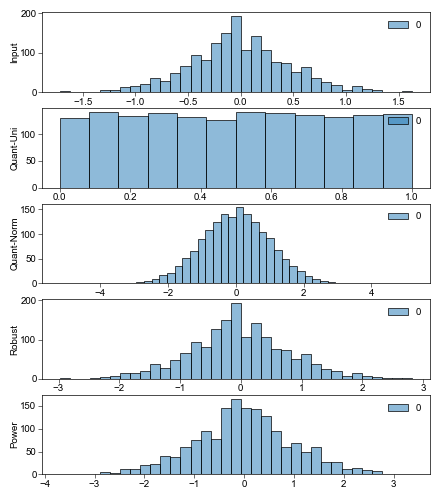

In [133]:
compare_transforms(all_feat, 'DiffRC_GO', log=False)

#### Transform features

In [134]:
all_x = []
x_qn = np.array(all_feat[quant_norm])
transformerqn = prep.QuantileTransformer(n_quantiles=len(x_qn), output_distribution='normal').fit(x_qn)
all_x.append(transformerqn.transform(x_qn))

#x_robust = np.log10(np.array(all_feat[log_robust]))
#transformer_robust = prep.RobustScaler().fit(x_robust)
#all_x.append(transformer_robust.transform(x_robust))

x_power = np.array(all_feat[power])
transformerp = prep.PowerTransformer().fit(x_power)
all_x.append(transformerp.transform(x_power))

all_x.append(np.array(all_feat[none]))

X = np.concatenate(all_x, axis=1)
#scaler = prep.MinMaxScaler().fit(X)
#X_scaled = scaler.transform(X)
#X2 = sm.add_constant(X_scaled)

In [135]:
scaler2 = prep.StandardScaler().fit(X)
X_scaled2 = scaler2.transform(X)
X3 = sm.add_constant(X_scaled2)

#### Transfrorm Target

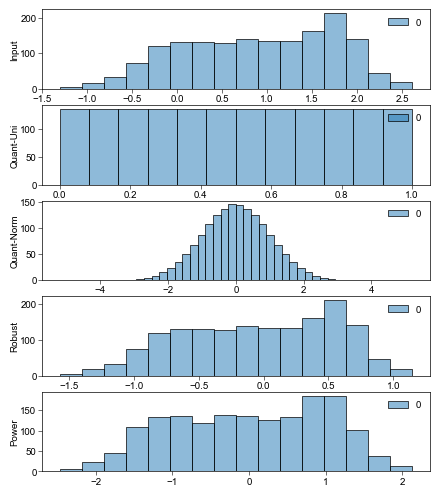

In [136]:
compare_transforms(all_feat, 'log2COLOC', log=False)

In [137]:
y = all_feat.log2COLOC.values.reshape(-1,1)
transformery = prep.QuantileTransformer(n_quantiles=len(y)).fit(y)
ynorm = transformery.transform(all_feat.log2COLOC.values.reshape(-1,1))

In [138]:
y.shape

(1629, 1)

### Cross-validation

In [140]:
feature_list = quant_norm + log_robust + power +none

In [141]:
def do_cv(X, y, feature_list):
    alphas = np.logspace(-5, 1, 20)
    cv = KFold(n_splits=5, shuffle=True, random_state=1984)
    enet_cv = ElasticNetCV(
        l1_ratio=[.1,.25, .4, .5, .6, .7, .8,  .9, .95, .99, 1],
        alphas=alphas,
        cv=cv,
        max_iter=1000,
        random_state=10,
        fit_intercept=True
    )

    enet_cv.fit(X[:, 1:], y.squeeze())
    print(f"Optimal alpha: {enet_cv.alpha_:.4f}")
    print(f"Optimal l1_ratio: {enet_cv.l1_ratio_:.4f}")
    print("Coefficients:", enet_cv.coef_)
    print("Intercept:", enet_cv.intercept_)
    y_pred = enet_cv.predict(X[:, 1:])
    print("Train MSE:", mean_squared_error(y.squeeze(), y_pred))
    print("Train R²:",  r2_score(y.squeeze(), y_pred))
    print("Coefficients:", [x for x in zip([feature_list+['intercept'], enet_cv.coef_])])
    return enet_cv

In [142]:
enet_cv2 = do_cv(X3, ynorm, feature_list)

Optimal alpha: 0.0144
Optimal l1_ratio: 0.1000
Coefficients: [ 0.         -0.00530273  0.03924193 -0.01168784  0.00030884  0.01567002
 -0.01023799 -0.00189512  0.00328501  0.00219148 -0.00514425  0.00308022
  0.03823507  0.0121296  -0.          0.00519877 -0.00285384  0.12121062
 -0.03619844 -0.05198023]
Intercept: 0.5000000000000001
Train MSE: 0.019495688625636266
Train R²: 0.7663387895764233
Coefficients: [(['N_C', 'N_R', 'assortativity_RC', 'Mean_LOEUF', 'DiffRC_LOEUF', 'DiffRC_GeneSize', 'DiffRC_nTissues', 'Mean_mRNA', 'DiffRC_mRNA', 'Mean_GeneSize', 'Mean_GO', 'DiffRC_GO', 'density_R', 'density_C', 'Mean_nTissues', 'g_C', 'g_R', 'J_RC', 'binary', 'jaccard_zero', 'intercept'],), (array([ 0.        , -0.00530273,  0.03924193, -0.01168784,  0.00030884,
        0.01567002, -0.01023799, -0.00189512,  0.00328501,  0.00219148,
       -0.00514425,  0.00308022,  0.03823507,  0.0121296 , -0.        ,
        0.00519877, -0.00285384,  0.12121062, -0.03619844, -0.05198023]),)]


In [143]:
best_alpha = enet_cv2.alpha_
best_l1=  enet_cv2.l1_ratio_
print('Best Alpha', best_alpha)
print('Best L1 Ratio', best_l1)

Best Alpha 0.01438449888287663
Best L1 Ratio 0.1


In [144]:
pd.DataFrame(X3,columns=feature_list+['intercept'], index=all_feat.index.values).N_R.describe()

count    1.629000e+03
mean    -2.180917e-17
std      1.000307e+00
min     -5.113853e+00
25%     -6.623668e-01
50%      2.702053e-03
75%      6.647415e-01
max      5.116227e+00
Name: N_R, dtype: float64

In [145]:
y_pred = enet_cv2.predict(X3[:,1:])

print("Train MSE:", mean_squared_error(ynorm.squeeze(), y_pred))
print("Train R²:",  r2_score(ynorm.squeeze(), y_pred))
print("Variance Explained:",  explained_variance_score(ynorm.squeeze(), y_pred))


Train MSE: 0.019495688625636266
Train R²: 0.7663387895764233
Variance Explained: 0.7663387895764233


Text(0, 0.5, 'Predicted values')

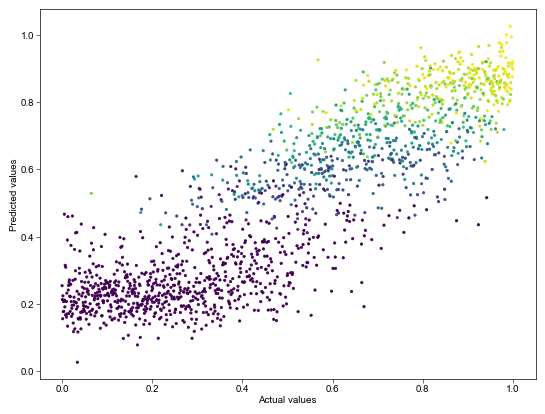

In [146]:
plt.scatter(ynorm, y_pred, s=3,c=X3[:, -3])
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

### Bootstrapping

In [148]:
B = 2000
coefs = np.zeros((B, X3[:, 1:].shape[1]))
r2 = []
intercepts = []

for b in range(B):
    # sample with replacement
    idx = np.random.choice(len(ynorm), len(ynorm), replace=True)
    Xb, yb = X3[:, 1:][idx], ynorm[idx]

    # refit final model
    model = ElasticNet(
        alpha=best_alpha,
        l1_ratio=best_l1,
        max_iter=1000,
        random_state=b
    ).fit(Xb, yb)

    coefs[b, :] = model.coef_
    yp = model.predict(Xb)
    r2.append( r2_score(yb.squeeze(), yp))
    intercepts.append(model.intercept_)
# compute bootstrap SEs
se = coefs.std(axis=0)
print("Coefficient SEs:", se)


Coefficient SEs: [0.00284059 0.00349762 0.00543535 0.00507239 0.00319151 0.00449018
 0.00459754 0.00297315 0.00401967 0.00408141 0.00409794 0.00349728
 0.0048717  0.00465248 0.00294419 0.00485091 0.00365733 0.00673168
 0.00565555 0.00732978]


In [149]:

bootstrap_means = coefs.mean(axis=0)
bootstrap_sds   = coefs.std(axis=0, ddof=1) # ddof=1 for sample‐std

# print mean ± SE
for j, (m, se) in enumerate(zip(bootstrap_means, bootstrap_sds)):
    print(f"β_{j}: {m:.4f} \u00B1 {se:.4f}")

print(f"R2: {np.mean(r2):.3f} \u00B1 {np.std(r2):.4f}")
print(f"Intercept: {np.mean(intercepts):.3f} \u00B1 {np.std(intercepts):.4f}")

β_0: 0.0006 ± 0.0028
β_1: -0.0053 ± 0.0035
β_2: 0.0394 ± 0.0054
β_3: -0.0120 ± 0.0051
β_4: 0.0015 ± 0.0032
β_5: 0.0154 ± 0.0045
β_6: -0.0107 ± 0.0046
β_7: -0.0021 ± 0.0030
β_8: 0.0036 ± 0.0040
β_9: 0.0027 ± 0.0041
β_10: -0.0053 ± 0.0041
β_11: 0.0034 ± 0.0035
β_12: 0.0380 ± 0.0049
β_13: 0.0121 ± 0.0047
β_14: -0.0003 ± 0.0029
β_15: 0.0056 ± 0.0049
β_16: -0.0031 ± 0.0037
β_17: 0.1217 ± 0.0067
β_18: -0.0363 ± 0.0057
β_19: -0.0514 ± 0.0073
R2: 0.770 ± 0.0090
Intercept: 0.500 ± 0.0034


In [150]:
lower_pct, upper_pct = 2.5, 97.5

# Compute the percentiles
ci_lower = np.percentile(coefs, lower_pct, axis=0)
ci_upper = np.percentile(coefs, upper_pct, axis=0)

for j, (low, high) in enumerate(zip(ci_lower, ci_upper)):
    print(f"β_{feature_list[j]} 95% CI (percentile): [{low:.4f}, {high:.4f}]")


β_N_C 95% CI (percentile): [-0.0057, 0.0070]
β_N_R 95% CI (percentile): [-0.0126, 0.0000]
β_assortativity_RC 95% CI (percentile): [0.0289, 0.0503]
β_Mean_LOEUF 95% CI (percentile): [-0.0217, -0.0021]
β_DiffRC_LOEUF 95% CI (percentile): [-0.0044, 0.0092]
β_DiffRC_GeneSize 95% CI (percentile): [0.0065, 0.0240]
β_DiffRC_nTissues 95% CI (percentile): [-0.0192, -0.0017]
β_Mean_mRNA 95% CI (percentile): [-0.0091, 0.0024]
β_DiffRC_mRNA 95% CI (percentile): [-0.0022, 0.0126]
β_Mean_GeneSize 95% CI (percentile): [-0.0037, 0.0122]
β_Mean_GO 95% CI (percentile): [-0.0139, 0.0000]
β_DiffRC_GO 95% CI (percentile): [-0.0017, 0.0110]
β_density_R 95% CI (percentile): [0.0280, 0.0474]
β_density_C 95% CI (percentile): [0.0032, 0.0210]
β_Mean_nTissues 95% CI (percentile): [-0.0075, 0.0059]
β_g_C 95% CI (percentile): [0.0000, 0.0166]
β_g_R 95% CI (percentile): [-0.0116, 0.0018]
β_J_RC 95% CI (percentile): [0.1088, 0.1349]
β_binary 95% CI (percentile): [-0.0476, -0.0253]
β_jaccard_zero 95% CI (percentile):

In [151]:

B, n_features = coefs.shape
pvals = np.zeros(n_features)
for j in range(n_features):
    # fraction of bootstraps ≤ 0 and ≥ 0
    if np.sum(coefs[:, j] < 0) + np.sum(coefs[:, j] > 0) > 0:
        frac_le = (np.sum(coefs[:, j] < 0) + 1)/(B+1)
        frac_ge = (np.sum(coefs[:, j] > 0) + 1)/(B+1) 
        # two-sided q-value
        pvals[j] = min(1, 2 * min(frac_le, frac_ge)*n_features)
    else:
        pvals[j] = np.nan
for j, p in enumerate(pvals):
    print(f"coef #{feature_list[j]}: p ≈ {p:.8f}")


coef #N_C: p ≈ 1.00000000
coef #N_R: p ≈ 0.47976012
coef #assortativity_RC: p ≈ 0.01999000
coef #Mean_LOEUF: p ≈ 0.01999000
coef #DiffRC_LOEUF: p ≈ 1.00000000
coef #DiffRC_GeneSize: p ≈ 0.01999000
coef #DiffRC_nTissues: p ≈ 0.03998001
coef #Mean_mRNA: p ≈ 1.00000000
coef #DiffRC_mRNA: p ≈ 1.00000000
coef #Mean_GeneSize: p ≈ 1.00000000
coef #Mean_GO: p ≈ 0.93953023
coef #DiffRC_GO: p ≈ 1.00000000
coef #density_R: p ≈ 0.01999000
coef #density_C: p ≈ 0.01999000
coef #Mean_nTissues: p ≈ 1.00000000
coef #g_C: p ≈ 0.47976012
coef #g_R: p ≈ 1.00000000
coef #J_RC: p ≈ 0.01999000
coef #binary: p ≈ 0.01999000
coef #jaccard_zero: p ≈ 0.01999000


### Table 1

In [152]:

coef_df = pd.DataFrame({
    'Feature': feature_list,
    'Coefficient': bootstrap_means,
    'CI Lower': ci_lower,
    'CI Upper': ci_upper,
    'P-Val': pvals
})

coef_df['95% CI'] = coef_df.apply(
    lambda row: f"({row['CI Lower']:.3f}, {row['CI Upper']:.3f})", axis=1)

order = [feature_names[x] for x in ['g_C', 'g_R', 'density_C', 'density_R', 'N_C', 'N_R', 
         'Mean_LOEUF', 'DiffRC_LOEUF', 'Mean_GeneSize', 'DiffRC_GeneSize', 'Mean_nTissues', 'DiffRC_nTissues',
         'Mean_mRNA', 'DiffRC_mRNA', 'Mean_GO', 'DiffRC_GO',
         'jaccard_zero',
        'J_RC', 'assortativity_RC', 'binary']]
coef_df['Feature'] = coef_df['Feature'].map(feature_names)
coef_df.set_index('Feature').loc[order, ( 'Coefficient', '95% CI', 'P-Val')].to_csv(os.path.join(figdir, 'elastic_net_coefs4_2000_test.tsv'), sep='\t')



In [153]:
coef_df

,Feature,Coefficient,CI Lower,CI Upper,P-Val,95% CI
0,Study Size - Common,0.000588,-0.005695,0.007003,1.00000,"(-0.006, 0.007)"
1,Study Size - Rare,-0.005335,-0.012606,0.000000,0.47976,"(-0.013, 0.000)"
2,Assortativity,0.039389,0.028902,0.050305,0.01999,"(0.029, 0.050)"
3,Mean LOEUF,-0.012004,-0.021668,-0.002072,0.01999,"(-0.022, -0.002)"
4,Diff. LOEUF,0.001533,-0.004418,0.009151,1.00000,"(-0.004, 0.009)"
5,Diff. Gene Size,0.015388,0.006462,0.024024,0.01999,"(0.006, 0.024)"
6,Diff. Exp. Tissues,-0.010709,-0.019221,-0.001694,0.03998,"(-0.019, -0.002)"
7,Mean Exp.,-0.002101,-0.009085,0.002364,1.00000,"(-0.009, 0.002)"
8,Diff. Exp.,0.003646,-0.002206,0.012620,1.00000,"(-0.002, 0.013)"
9,Mean Gene Size,0.002663,-0.003738,0.012177,1.00000,"(-0.004, 0.012)"


### Residuals calculation

In [154]:
residuals = np.subtract(ynorm.squeeze(), y_pred.squeeze())

In [161]:
resid_df = pd.DataFrame({'log2COLOC_norm':ynorm.squeeze(), 'log2COLOC':y.squeeze(), 'Prediction':y_pred, 'Residual':residuals}, index=all_feat.trait_pair.values)

In [162]:
resid_df.to_csv(os.path.join(datadir, 'outputs/residuals_mod4.tsv'), sep='\t')

In [163]:
resid_df = pd.read_csv(os.path.join(datadir, 'outputs/residuals_mod4.tsv'), sep='\t', index_col=0)

### SFigure 2B

In [165]:
all_feat_h2 = all_feat_h2.drop(columns=['log2COLOC']).merge(resid_df.reset_index(names=['trait_pair']), on='trait_pair', how='left')

In [167]:
r_h2_res = all_feat_h2.loc[:, ('log2COLOC', 'Residual', 'SNP-Heritability')].corr(method='spearman').at['Residual', 'SNP-Heritability']

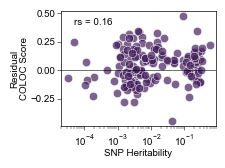

In [168]:
_ = plt.figure(figsize=(2,1.5))
#sns.scatterplot(all_feat_h2, y='log2COLOC', x='h2_observed', alpha=0.7, color='grey')
sns.scatterplot(all_feat_h2, y='Residual', x='SNP-Heritability', alpha=0.7, color=purple)
plt.hlines(y=0, xmin=-0.05, xmax=0.9, color='black', linewidth=0.4)
#plt.hlines(y=[np.log2(1.3), np.log2(2.5)], xmin=-0.05, xmax=0.9, color='black', linewidth=0.4, linestyle='--')
plt.xlim(0.00002, 0.9)
ax1 = plt.gca()
#ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
#_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
_ =ax1.set_ylabel('Residual\nCOLOC Score')
_ =ax1.set_xlabel('SNP Heritability')
_ = plt.text(x=0.00005, y=0.4, s=f'rs = {r_h2_res:.2f}')
plt.xscale('log')
#plt.savefig(os.path.join(figdir, 'heritability_scatter_adjusted.svg'), bbox_inches='tight')

## Feature examination

### Figure 4D

In [169]:
def plot_fraction_by_y_quantile_bars(
    X_df: pd.DataFrame,
    y_df: pd.DataFrame,
    y_col: str,
    group_col: str = None,
    group_order: list = None,
    n_quantiles: int = 10,
    subset_features: list = None,
    feature_name_map: dict = None,
    figsize: tuple = (10, 6),
    colors: list = None,
    ax: plt.Axes = None,
    plot_violin=False
):
    """
    Plot feature means ± SEM across either y-quantile bins or predefined groups.

    Parameters
    ----------
    X_df : pd.DataFrame
        Feature DataFrame (n_samples x n_features).
    y_df : pd.DataFrame
        DataFrame containing the target column and optional group column.
    y_col : str
        Name of the column in y_df to use as the continuous target (for quantiles).
    group_col : str, optional
        Name of the column in y_df to use as categorical grouping. If provided,
        samples are grouped by this column instead of quantiles.
    group_order : list of str, optional
        Desired order of categories in group_col. Categories not present are dropped.
    n_quantiles : int, default=10
        Number of equal-sized bins to cut y into (used only if group_col is None).
    subset_features : list of str, optional
        Names of features in X_df to plot. If None, all columns of X_df are used.
    feature_name_map : dict, optional
        Mapping from X_df column names to display names for plotting.
    figsize : tuple, optional
        Matplotlib figure size.
    colors : list of str, optional
        List of colors for each feature line.
    ax : matplotlib.axes.Axes, optional
        Axes object to draw on; if None, a new figure and axes are created.
    """
    # Join X and y on index
    merged = X_df.join(y_df[[y_col] + ([group_col] if group_col else [])], how='inner')

    # Select features
    all_features = X_df.columns.tolist()
    features_to_plot = subset_features if subset_features else all_features
    X = merged[features_to_plot].values

    # Determine grouping or quantiles
    if group_col:
        _ = plt.figure(figsize=(2,1.5))
        class_counts = all_feat[group_col].value_counts().to_dict()
        plot_df = (1- all_feat.groupby(group_col)[subset_features].mean()).melt(ignore_index=False).reset_index()
        order=['Negative','None', 'Weak', 'Moderate', 'Strong']
        sns.barplot(plot_df, order=order,
                    x=group_col, y='value', hue='variable',
                   palette=colors, saturation=1, edgecolor='black')

        plt.xticks([i for i in range(5)], labels=[f'{x}\n(n={class_counts[x]})' for x in order])
        plt.tick_params(axis='x', rotation=90)
    else:
        y = merged[y_col].values
        try:
            bins = pd.qcut(y, q=n_quantiles, labels=False, duplicates='drop')
        except ValueError:
            rank = np.argsort(np.argsort(y))
            bins = np.floor((rank / len(y)) * n_quantiles).astype(int)
            bins[bins == n_quantiles] = n_quantiles - 1
        unique_bins = np.unique(bins)
        labels = [f"{(i+1)*10}" for i in unique_bins]
        n_bins = len(unique_bins)

        # Compute per-bin means and SEM
        means = np.zeros((n_bins, X.shape[1]))
        x = np.arange(n_bins)
        for i in range(n_bins):
            vals = X[bins == i]
            means[i] = vals.mean(axis=0)
        plot_df = pd.DataFrame(means, columns=subset_features).melt(ignore_index=False).reset_index()

        # Create axes if needed
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
            sns.barplot(plot_df, x='index', y='value', hue='variable', palette=colors, order=x, ax=ax,
                       saturation=1, edgecolor='black')
            ax.set_xticks(x, labels)
    # Plot each feature line
    
  

In [170]:
all_feat = all_feat.set_index('trait_pair')
all_feat.index.name=''

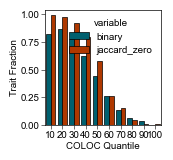

In [171]:
plot_fraction_by_y_quantile_bars(
     all_feat.drop(columns=['log2COLOC']),
     resid_df,
    y_col='log2COLOC',
     n_quantiles=10,
     feature_name_map=feature_names,
     subset_features=['binary', 'jaccard_zero'],
        figsize=(1.5,1.5),
        colors=[binary, shared],
        ax=None
 )
_ = plt.ylabel('Trait Fraction')
_ = plt.xlabel('COLOC Quantile')
#plt.savefig(os.path.join(figdir, 'binary_jaccard_q10.svg'), bbox_inches='tight')

### Figure 4E

In [172]:
def plot_feature_means_by_y_quantile_lines(
    X_df: pd.DataFrame,
    y_df: pd.DataFrame,
    y_col: str,
    group_col: str = None,
    group_order: list = None,
    n_quantiles: int = 10,
    subset_features: list = None,
    feature_name_map: dict = None,
    figsize: tuple = (10, 6),
    colors: list = None,
    ax: plt.Axes = None,
    plot_violin=False,
    markersize=4
):
    """
    Plot feature means ± SEM across either y-quantile bins or predefined groups.
    If plot_violin=True, show a violin of the raw feature-values in each bin 
    (for each feature).

    Parameters
    ----------
    X_df : pd.DataFrame
        Feature DataFrame (n_samples x n_features).
    y_df : pd.DataFrame
        DataFrame containing the target column and optional group column.
    y_col : str
        Name of the column in y_df to use as the continuous target (for quantiles).
    group_col : str, optional
        Name of the column in y_df to use as categorical grouping. If provided,
        samples are grouped by this column instead of quantiles.
    group_order : list of str, optional
        Desired order of categories in group_col. Categories not present are dropped.
    n_quantiles : int, default=10
        Number of equal-sized bins to cut y into (used only if group_col is None).
    subset_features : list of str, optional
        Names of features in X_df to plot. If None, all columns of X_df are used.
    feature_name_map : dict, optional
        Mapping from X_df column names to display names for plotting.
    figsize : tuple, optional
        Matplotlib figure size.
    colors : list of str, optional
        List of colors for each feature line or hue for violins.
    ax : matplotlib.axes.Axes, optional
        Axes object to draw on; if None, a new figure and axes are created.
    plot_violin : bool, default=False
        If True, draw a violinplot of the raw datapoints in each bin (for each feature)
        instead of the mean±SEM lines.
    markersize : int, default=4
        Marker size for the errorbar plot (if plot_violin=False).
    """
    # Join X and y on index
    merged = X_df.join(y_df[[y_col] + ([group_col] if group_col else [])], how='inner')

    # Select which features to plot
    all_features = X_df.columns.tolist()
    features_to_plot = subset_features if subset_features else all_features

    # If feature_name_map is given, build a dict for display
    if feature_name_map:
        display_names = [feature_name_map.get(f, f) for f in features_to_plot]
    else:
        display_names = features_to_plot.copy()

    # Determine grouping (either by group_col or by quantiles of y_col)
    if group_col:
        groups = merged[group_col].astype(str)
        if group_order:
            unique_groups = [g for g in group_order if g in groups.unique()]
        else:
            unique_groups = list(pd.Categorical(groups).categories)

        bin_index = {g: i for i, g in enumerate(unique_groups)}
        bins = groups.map(bin_index).values
        labels = unique_groups
        n_bins = len(unique_groups)

    else:
        y = merged[y_col].values
        try:
            bins = pd.qcut(y, q=n_quantiles, labels=False, duplicates='drop')
        except ValueError:
            # fallback to a rank‐based binning if qcut fails
            rank = np.argsort(np.argsort(y))
            bins = np.floor((rank / len(y)) * n_quantiles).astype(int)
            bins[bins == n_quantiles] = n_quantiles - 1
        unique_bins = np.unique(bins)
        # use percentiles as x‐tick labels
        labels = [int((i + 1) * (100 / n_quantiles)) for i in unique_bins]
        n_bins = len(unique_bins)

    # Extract X as numpy array for mean/SEM computation
    X = merged[features_to_plot].values

    # Compute per‐bin means and SEMs (only used if plot_violin=False)
    means = np.zeros((n_bins, X.shape[1]))
    sems = np.zeros_like(means)
    for i in range(n_bins):
        vals = X[bins == i]
        means[i, :] = vals.mean(axis=0)
        sems[i, :] = vals.std(axis=0, ddof=1) / np.sqrt(len(vals))

    # Create axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    x = np.arange(n_bins)
    
    
            # Build a long‐form DataFrame of raw feature‐values with their bin indices
    plot_df = merged[features_to_plot].copy()
    plot_df['bin'] = bins

    # Melt so that each row is: (bin, feature_name, raw_value)
    melted = plot_df.melt(
        id_vars=['bin'],
        value_vars=features_to_plot,
        var_name='feature',
        value_name='value'
    )

    # Map feature → display name if provided
    if feature_name_map:
        melted['feature_display'] = melted['feature'].map(
            lambda f: feature_name_map.get(f, f)
        )
    else:
        melted['feature_display'] = melted['feature']
    

    if not plot_violin:
        # Standard line + errorbar plot of mean ± SEM for each feature
        for idx, name in enumerate(display_names):
            color = colors[idx] if colors and idx < len(colors) else None
            ax.errorbar(
                x,
                means[:, idx],
                yerr=0, #sems[:, idx],
                fmt='-o',
                capsize=3,
                markersize=markersize,
                color=color,
                label=name,
                zorder=10
            )
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')


    else:

        # Now plot one violin per (bin, feature). Use 'hue' to separate features.
        # If you only passed a single feature, hue will be trivial.
        sns.violinplot(
            x='bin',
            y='value',
            hue='feature_display',
            data=melted,
            palette=colors,
            cut=0,
            ax=ax,
            fill=False,
            inner="quart",
            linewidth=0.5
        )
        # Optionally, if you want to dodge violins per feature side‐by‐side, seaborn will handle it.
        # If you want no legend when only one feature, you can do:
        if len(features_to_plot) == 1:
            ax.get_legend().remove()
        else:
            ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

    # Final formatting
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel(group_col if group_col else y_col)
    ax.set_ylabel("Feature value" if plot_violin else "Mean feature value")
    title = (
        f"Feature means ± SEM across groups '{group_col}'"
        if group_col else
        f"Feature means ± SEM across {n_quantiles} Y quantiles"
    )


    # Return a small DataFrame for debugging / further use if desired
    z = pd.DataFrame({'y': merged[y_col].values, 'bin': bins})
    return z, melted

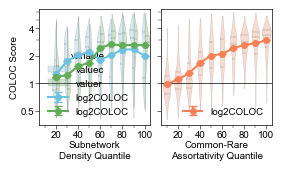

In [173]:
_, [ax1,ax2] = plt.subplots(ncols=2, nrows=1, figsize=(3, 1.5), sharey=True, gridspec_kw={'wspace':0.1})
a, am = plot_feature_means_by_y_quantile_lines(
     resid_df,
     all_feat.drop(columns=[]),
    
    y_col='density_C',
     n_quantiles=10,
     feature_name_map=feature_names,
     subset_features=['log2COLOC'],
        figsize=(2.5,1.5),
        colors=[blue],
        ax=ax1,
    markersize=4,
    plot_violin=False
 )
b, bm = plot_feature_means_by_y_quantile_lines(
    resid_df,
     all_feat.drop(columns=[]),
     
    y_col='density_R',
     n_quantiles=10,
     feature_name_map=feature_names,
     subset_features=['log2COLOC'],
        figsize=(2.5,1.5),
        colors=[green],
        ax=ax1,
    markersize=4
 )
ax1.set_xticks([0,2,4,6,8], labels=[20,40,60,80,100])
_= ax1.set_xticks([-1, 1,3,5,7], minor=True)
#ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
#_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)

c, cm = plot_feature_means_by_y_quantile_lines(
     resid_df,
     all_feat.drop(columns=[]),
    
    y_col='assortativity_RC',
     n_quantiles=10,
     feature_name_map=feature_names,
     subset_features=['log2COLOC'],
        figsize=(2.5,1.5),
        colors=['#F78154'],
        ax=ax2, 
    markersize=4
 )
ax1.set_xlabel('Subnetwork\nDensity Quantile')
ax2.set_xlabel('Common-Rare\nAssortativity Quantile')
ax2.set_xticks([1,3,5,7,9], labels=[20,40,60,80,100])
_= ax2.set_xticks([0, 2,4,6,8], minor=True)

am = am.sort_values('bin').reset_index(drop=True)
bm = bm.sort_values('bin').reset_index(drop=True)
all_m = am.join(bm, lsuffix='c', rsuffix='r').melt(id_vars='binc', value_vars=['valuec', 'valuer'])
sns.violinplot(all_m, x='binc', y='value', hue='variable', split=True, fill=True, inner='quart', 
               alpha=0.3, palette=[blue, green], zorder=0, ax=ax1, cut=0, linewidth=0.3)

sns.violinplot(cm, x='bin', y='value', fill=True, inner='quart', 
               alpha=0.3, color='#F78154', zorder=0, ax=ax2, cut=0, linewidth=0.3)

for ax in [ax1, ax2]:
    ax.set_ylim(-1.5, 2.7)
    
    ax.hlines(y=0, xmin=-2, xmax=10, color='black', linewidth=0.5)
ax1.set_xlim(-1.5, 8.5)
ax2.set_xlim(-0.5, 9.5)
ax1.set_ylabel('COLOC Score')
ax2.set_ylabel('')
ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
#ax1.set_yticks([0, 1, np.log2(4)], labels=[1, 2,  4])
#_ = ax1.set_yticks(np.log2([0.9]+[1+i/10 for i in range(1,10)]+[2+i/10 for i in range(1, 10)]+[3.1]), minor=True)

#_ = ax1.set_yticks([0, 0.1, 0.2, 0.3])
#_ = ax2.set_yticks([0, 0.005, 0.01])
#_ = ax1.set_xlabel('')
#_ = ax1.set_ylabel('Subnetwork\nDensity')
#_ = ax2.set_ylabel('Common-Rare\nAssortativity')

#sns.violinplot(a, x='bin', y='y', ax=ax1)
#plt.savefig(os.path.join(figdir, 'net_features.svg'), bbox_inches='tight')

### Figure 4F

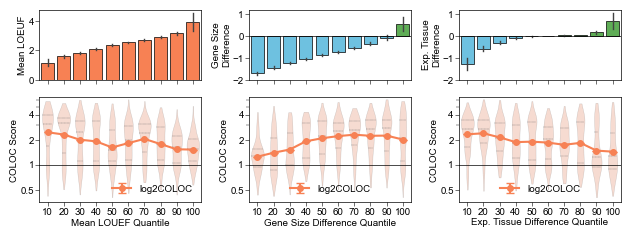

In [174]:
_, [[ax4,ax5,ax6],[ax1, ax2, ax3]] = plt.subplots(ncols=3, nrows=2, figsize=(7.5, 2.5), sharey=False, sharex='col',
                                                  gridspec_kw={'hspace':0.2, 'wspace':0.3,
                                 'height_ratios':[2,3]})

a, am = plot_feature_means_by_y_quantile_lines(
    resid_df,
     all_feat.drop(columns=[]),
     
    y_col='Mean_LOEUF',
     n_quantiles=10,
     feature_name_map=feature_names,
     subset_features=['log2COLOC'],
        figsize=(2,1.5),
        colors=['#F78154'],
        ax=ax1,
    markersize=4
 )

sns.violinplot(am, x='bin', y='value', fill=True, inner='quart', 
               alpha=0.3, color='#F78154', zorder=0, ax=ax1, cut=0, linewidth=0.3)
ax1.set_ylabel('COLOC Score')
ax1.set_xlabel('Mean LOUEF Quantile')
sns.barplot(a, x='bin', y='y', ax=ax4,errorbar='sd', err_kws={'linewidth':1}, color='#F78154',
           edgecolor='black', saturation=1)
ax4.set_ylabel('Mean LOEUF')
#_ = ax1.set_yticks([1.5, 2, 2.5,3])

#_ = ax1.set_xlabel('')
b, bm = plot_feature_means_by_y_quantile_lines(
    resid_df,
     all_feat.drop(columns=[]),
     
    y_col='DiffRC_GeneSize',
     n_quantiles=10,
     feature_name_map=feature_names,
     subset_features=['log2COLOC'],
        figsize=(2,1.5),
        colors=['#F78154'],
        ax=ax2,
    markersize=4
 )
bb = b.groupby('bin').y.mean().reset_index()
bb['color'] = bb.y.apply(lambda x: blue if x <0 else green)
ax2.set_ylabel('COLOC Score')
ax2.set_xlabel('Gene Size Difference Quantile')
sns.violinplot(bm, x='bin', y='value', fill=True, inner='quart', 
               alpha=0.3, color='#F78154', zorder=0, ax=ax2, cut=0, linewidth=0.3)
#_ = ax2.set_yticks([0, -0.25, -0.5, -0.75, -1])

sns.barplot(b, x='bin', y='y', ax=ax5,errorbar='sd', err_kws={'linewidth':1}, hue='bin', legend=False,
           palette=list(bb.color.values), saturation=1, edgecolor='black')

ax5.set_ylabel('Gene Size\nDifference')
ax5.hlines(y=0, xmin=-0.5, xmax=9.5, color='black', linewidth=0.5)
ax5.set_xlim(-0.5, 9.5)

#_ = ax2.set_xlabel('')
c, cm = plot_feature_means_by_y_quantile_lines(
     resid_df,
     all_feat.drop(columns=[]),
    
    y_col='DiffRC_nTissues',
     n_quantiles=10,
     feature_name_map=feature_names,
     subset_features=['log2COLOC'],
        figsize=(2,1.5),
        colors=['#F78154'],
        ax=ax3,
    markersize=4
 )
sns.violinplot(cm, x='bin', y='value', fill=True, inner='quart', 
               alpha=0.3, color='#F78154', zorder=0, ax=ax3, cut=0, linewidth=0.3)
ax3.set_ylabel('COLOC Score')
ax3.set_xlabel('Exp. Tissue Difference Quantile')
cc = c.groupby('bin').y.mean().reset_index()
cc['color'] = cc.y.apply(lambda x: blue if x <0 else green)
sns.barplot(c, x='bin', y='y', ax=ax6, errorbar='sd', err_kws={'linewidth':1}, hue='bin', legend=False,
           palette = list(cc.color.values), saturation=1, edgecolor='black')
ax6.set_ylabel('Exp. Tissue\nDifference')
ax6.hlines(y=0, xmin=-0.5, xmax=9.5, color='black', linewidth=0.5)
ax6.set_xlim(-0.5, 9.5)

for ax in [ax5, ax6]:
    ax.set_ylim(-2, 1.2)
    ax.set_yticks([-2, -1, 0, 1])
for ax in [ax1, ax2, ax3]:
    ax.set_ylim(-1.5, 2.7)
    ax.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
    _ = ax.set_yticks(np.log2([3,5,6]), minor=True)
    ax.hlines(y=0, xmin=-2, xmax=10, color='black', linewidth=0.5)
    ax.set_xlim(-0.5, 9.5)
#_ = ax3.set_yticks([0.1, 0, -0.1, -0.2, -0.3])
#plt.savefig(os.path.join(figdir, 'bio_features_q10.svg'), bbox_inches='tight')

## Tissue Specificty

In [185]:
def load_results(file_name, best_df):
    tiss_df = pd.read_csv(os.path.join(datadir, 'outputs', 
                                       file_name), sep='\t')
    tiss_df = tiss_df.assign(Domain=tiss_df.GeneSet.map(best_df.set_index('trait_pair').Domain.to_dict()))
    tiss_df = tiss_df.assign(name=tiss_df.GeneSet.map(best_df.set_index('trait_pair')['Trait'].to_dict()))
    tiss_df['Domain']  = tiss_df.Domain.apply(lambda x: x.lower())
    tiss_df['log2FoldChange'] = np.log2(tiss_df['fold.change'])
    tiss_df['EFO'] = tiss_df.GeneSet.map(best_df.set_index('trait_pair')['EFO'].to_dict())
    return tiss_df


In [186]:
info_df = pd.read_csv(os.path.join(datadir, 'outputs/STable1.tsv'), sep='\t', usecols=['Mapped EFO', 'Trait Type', 
                                                                              'Biological Domain', 'Mapped Trait']).drop_duplicates()
info_df.columns = ['EFO', 'trait_type', 'Domain', 'TRAIT']

In [190]:
best_df = best_df.reset_index().merge(domain_info.loc[:, ('EFO', 'Domain')], on=['EFO'], how='left')


In [191]:
rare_net = load_results('RVG_tissue_enrichment_HPA.txt', best_df)
common_net = load_results('CVG_tissue_enrichment_HPA.txt', best_df)

/cellar/users/snwright/anaconda3/envs/carva/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cellar/users/snwright/anaconda3/envs/carva/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [195]:
bio_df = pd.read_csv(os.path.join(cwd, '../outputs/Raw_geneset_gene_features.txt'), sep='\t', index_col=0).loc[:, [ 'pli', 'Length', 'GO', 'mrna', 'n_mrna', 'Set']]
bio_df.columns = ['LOEUF', 'GeneSize', 'GO', 'mRNA', 'nTissues', 'Set']

In [223]:
best_df['TraitC'] = best_df['Common Study'] + '_' + best_df['EFO']
best_df['TraitR'] = best_df['Rare Study'].astype(int).astype(str) + '_' + best_df['EFO']

In [224]:
RVG_low= all_feat.loc[best_df.trait_pair.values].sort_values('DiffRC_nTissues').head(15).index.values
test_rare = best_df[best_df.trait_pair.isin(RVG_low)].copy()

In [225]:
CVG_low= all_feat.loc[best_df.trait_pair.values].sort_values('DiffRC_nTissues', ascending=False).head(15).index.values
test_common = best_df[best_df.trait_pair.isin(CVG_low)].copy()

In [226]:

rare_tissues = {'free cholesterol in very small VLDL measurement': 'Liver',
       'heel bone mineral density': None, 'bilirubin measurement': 'Liver',
       'total lipids in very small VLDL measurement': 'Liver',
       'low density lipoprotein cholesterol measurement': 'Liver',
       'cholelithiasis': 'Liver', 'glucose measurement': 'Pancreas', 'choline measurement': 'Liver',
       'coronary artery disease': 'Heart Muscle', 'actinic keratosis': 'Skin',
       'rheumatoid arthritis': None, 'pathological myopia': None, 'insomnia': 'Cerebral Cortex',
       'Headache':'Cerebral Cortex', 'rheumatic fever': 'None'}
test_rare['tiss'] = test_rare['Trait'].map(rare_tissues)

common_tissues = {'neutrophil count': 'Bone Marrow', 'apolipoprotein B measurement': 'Liver', 'gallstones':'Liver',
       'omega-3 polyunsaturated fatty acid measurement':'Liver',
       'whole-brain volume':'Cerebral Cortex', 'retinal detachment':None, 'endometriosis':'Endometrium',
       'Cholecystitis': 'Liver', 'ulcerative colitis':'Colon', 'sick sinus syndrome':None,
       'diaphragmatic hernia':'Smooth Muscle', 'anxiety disorder':'Cerebral Cortex', 'pulmonary embolism':'Heart Muscle',
       'osteoarthritis, hip': None, 'panic disorder':'Cerebral Cortex'}
test_common['tiss'] = test_common['Trait'].map(common_tissues)

In [227]:
out = []
for gs, tiss in zip(test_rare.trait_pair.values, test_rare.tiss.values):
    if tiss is None:
        continue
    tiss_df = rare_net[rare_net.GeneSet==gs]
    out.append(tiss_df[tiss_df.Tissue==tiss])

In [228]:
outc = []
for gs, tiss in zip(test_common.trait_pair.values, test_common.tiss.values):
    if tiss is None:
        continue
    tiss_df = common_net[common_net.GeneSet==gs]
    outc.append(tiss_df[tiss_df.Tissue==tiss])

In [229]:
pd.concat(outc)

,GeneSet,Tissue,Log10PValue,Tissue.Specific.Genes,fold.change,samples,NotIdentifiedCount,Domain,name,log2FoldChange,EFO
9737,34375979_EFO_0000729_GCST90454275_EFO_0000729,Colon,0.000000,0,0.000000,13,0,gastrointestinal,ulcerative colitis,-inf,EFO_0000729
7674,28900119_EFO_0001065_GCST90018839_EFO_0001065,Endometrium,0.000000,0,0.000000,5,0,reproductive,endometriosis,-inf,EFO_0001065
10653,34375979_EFO_0003827_GCST90278093_EFO_0003827,Heart Muscle,0.008086,1,8.452306,4,0,cardiovascular,pulmonary embolism,3.079345,EFO_0003827
6630,34375979_EFO_0004210_GCST003725_EFO_0004210,Liver,0.000000,1,4.969458,10,0,gastrointestinal,gallstones,2.313088,EFO_0004210
12745,34375979_EFO_0004262_GCST000320_EFO_0004262,Cerebral Cortex,0.000000,1,1.288328,3,0,psychiatric,panic disorder,0.365500,EFO_0004262
610,34375979_EFO_0004615_GCST90025952_EFO_0004615,Liver,0.000000,1,11.181280,10,0,lipid measurment,apolipoprotein B measurement,3.483013,EFO_0004615
353,34662886_EFO_0004833_GCST90025977_EFO_0004833,Bone Marrow,0.475180,2,13.152613,4,0,immunological,neutrophil count,3.717278,EFO_0004833
6725,34662886_EFO_0005089_GCST000891_EFO_0005089,Cerebral Cortex,0.000000,0,0.000000,3,0,neurological,whole-brain volume,-inf,EFO_0005089
10540,34375979_EFO_0006788_GCST002696_EFO_0006788,Cerebral Cortex,0.000000,1,0.805205,3,0,psychiatric,anxiety disorder,-0.312572,EFO_0006788
10073,34375979_EFO_0008561_GCST90140994_EFO_0008561,Smooth Muscle,0.000000,0,0.000000,3,0,muscular,diaphragmatic hernia,-inf,EFO_0008561


In [230]:
all_ts = pd.concat([pd.concat(outc).merge(test_common.loc[:, ('Trait', 'Log2SizeOE')], left_on='name', right_on='Trait').assign(Group='Common'), pd.concat(out).merge(test_rare.loc[:, ('Trait', 'Log2SizeOE')], left_on='name', right_on='Trait').assign(Group='Rare')])

### Figure 5A

In [231]:
test_rare

,index,EFO,Trait,Common Study,Rare Study,Analysis Set,nCommon,nRare,nShared,pShared,...,Expected Size ST,Log2SizeOE ST,COLOC Score ST,COLOC P ST,COLOC -logp ST,trait_pair,Domain,TraitC,TraitR,tiss
25,109,EFO_0000685,rheumatoid arthritis,GCST90131437,20549515,Additional,26,5,0,6.824122e-03,...,154.203,1.767487,3.404603,3.178000e-244,243.497846,20549515_EFO_0000685_GCST90131437_EFO_0000685,Immunological,GCST90131437_EFO_0000685,20549515_EFO_0000685,None
39,201,EFO_0001645,coronary artery disease,GCST90446534,24507775,Additional,33,4,1,1.751401e-05,...,178.849,1.812023,3.511342,0.000000e+00,250.000000,24507775_EFO_0001645_GCST90446534_EFO_0001645,Cardiovascular,GCST90446534_EFO_0001645,24507775_EFO_0001645,Heart Muscle
41,208,EFO_0002496,actinic keratosis,GCST90095184,34375979,Initial,8,3,1,4.653005e-07,...,123.366,1.777713,3.428822,8.762000e-194,193.057397,34375979_EFO_0002496_GCST90095184_EFO_0002496,Dermatological,GCST90095184_EFO_0002496,34375979_EFO_0002496,Skin
67,285,EFO_0004207,pathological myopia,GCST001712,34375979,Initial,23,6,0,7.242163e-03,...,133.806,0.505857,1.419966,5.133000e-08,7.289629,34375979_EFO_0004207_GCST001712_EFO_0004207,Opthamological,GCST001712_EFO_0004207,34375979_EFO_0004207,None
91,419,EFO_0004468,glucose measurement,GCST90092819,34226706,Additional,12,5,1,3.652854e-06,...,159.467,2.096514,4.276747,0.000000e+00,250.000000,34226706_EFO_0004468_GCST90092819_EFO_0004468,Metabolic,GCST90092819_EFO_0004468,34226706_EFO_0004468,Pancreas
102,572,EFO_0004570,bilirubin measurement,GCST90018973,34375979,Initial,83,16,3,5.919738e-07,...,80.634,2.146464,4.427413,7.765000e-230,229.109859,34375979_EFO_0004570_GCST90018973_EFO_0004570,Hematological,GCST90018973_EFO_0004570,34375979_EFO_0004570,Liver
107,660,EFO_0004611,low density lipoprotein cholesterol measurement,GCST90239612,36564505,Additional,31,7,4,1.726201e-13,...,149.842,1.967459,3.910786,0.000000e+00,250.000000,36564505_EFO_0004611_GCST90239612_EFO_0004611,Lipid Measurment,GCST90239612_EFO_0004611,36564505_EFO_0004611,Liver
114,754,EFO_0004698,insomnia,GCST90131901,34375979,Initial,511,3,0,7.853771e-02,...,93.768,-0.401277,0.757188,1.241000e-02,1.906228,34375979_EFO_0004698_GCST90131901_EFO_0004698,Psychiatric,GCST90131901_EFO_0004698,34375979_EFO_0004698,Cerebral Cortex
119,783,EFO_0004799,cholelithiasis,GCST90018819,37262146,Additional,26,9,3,3.454084e-10,...,116.137,2.203711,4.606628,0.000000e+00,250.000000,37262146_EFO_0004799_GCST90018819_EFO_0004799,Gastrointestinal,GCST90018819_EFO_0004799,37262146_EFO_0004799,Liver
177,1148,EFO_0009270,heel bone mineral density,GCST90025982,34662886,Additional,9,5,2,7.345689e-10,...,140.932,2.276886,4.846309,0.000000e+00,250.000000,34662886_EFO_0009270_GCST90025982_EFO_0009270,Skeletal,GCST90025982_EFO_0009270,34662886_EFO_0009270,None


In [232]:

all_genesets = test_rare.TraitC.to_list() + test_rare.TraitR.to_list() + test_common.TraitC.to_list() + test_common.TraitR.to_list()


In [233]:
test_rare.columns

Index(['index', 'EFO', 'Trait', 'Common Study', 'Rare Study', 'Analysis Set',
       'nCommon', 'nRare', 'nShared', 'pShared', 'Network', 'Observed Size',
       'Expected Size', 'Log2SizeOE', 'COLOC Score', 'COLOC p', 'COLOC -logp',
       'Optimal COLOC', 'Observed Size PC22', 'Expected Size PC22',
       'Log2SizeOE PC22', 'COLOC Score PC22', 'COLOC P PC22',
       'COLOC -logp PC22', 'Observed Size HN', 'Expected Size HN',
       'Log2SizeOE HN', 'COLOC Score HN', 'COLOC P HN', 'COLOC -logp HN',
       'Observed Size ST', 'Expected Size ST', 'Log2SizeOE ST',
       'COLOC Score ST', 'COLOC P ST', 'COLOC -logp ST', 'trait_pair',
       'Domain', 'TraitC', 'TraitR', 'tiss'],
      dtype='object')

In [234]:
bio_df = bio_df.loc[all_genesets]
bio_df['EFO'] = bio_df.index.map(lambda x: x.split('_', 1)[-1])

In [238]:
a =  bio_df.pivot(index='EFO', columns='Set', values='nTissues').reset_index()
a['DiffRC'] = 2 * (a.Rare - a.Common)/ (a.Rare + a.Common)
a = a.sort_values(by='DiffRC', ascending=True)

In [239]:
def clean_label(label_str):
    out_str = label_str.replace('measurement', 'meas.')
    return out_str.capitalize()

Text(0, 0.5, '')

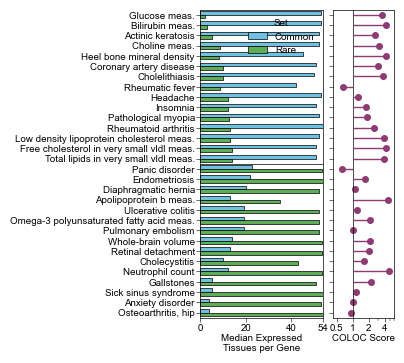

In [243]:
purple = '#8d3b72'
# do I take out the ones without relevant tissues? Probably. 
_ , [ax1, ax2] = plt.subplots(nrows=1, ncols=2, sharey=True, figsize= (2.5, 4), gridspec_kw={'width_ratios': [1, 0.5], 'wspace':0.1})
sns.barplot(bio_df, y='EFO', x='nTissues', hue='Set', palette=[blue, green], edgecolor='black', order=a.EFO.values, saturation=1, ax=ax1, width=0.7)
ax1.tick_params(axis='y', rotation=0)
_ = ax1.set_yticks(ax1.get_yticks(), labels=[clean_label(best_df.set_index('EFO')['Trait'].to_dict()[x]) for x in a.EFO.values], rotation=0, ha='right')
_ = ax1.set_xticks([0, 20, 40, 54])
ax1.set_xlim(0, 54)
sns.pointplot(best_df, y='EFO', x='Log2SizeOE', order=a.EFO.values, color=purple, ax=ax2, markersize=3, linestyle='None')
ax2.vlines(x=0, ymin=-0.5, ymax=29.5, color='black', linewidth=0.5)
ax2.set_ylim(29.5, -0.5)
coloc = best_df[best_df.EFO.isin(a.EFO.values)].set_index('EFO').Log2SizeOE.to_dict()
for x in a.EFO.values:
    ax2.hlines(y=x, xmin=min(0, coloc[x]), xmax=max(0, coloc[x]), color=purple, linewidth=1)
ax2.set_xlim(-1.25, 2.5)

ax2.set_xticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax2.set_xticks(np.log2([3,5,6]), minor=True)
ax2.set_xlabel('COLOC Score')
ax1.set_xlabel('Median Expressed\nTissues per Gene')
ax1.hlines(y=14.5, xmin=0, xmax=54, color='black', linewidth=0.5)
ax1.set_ylabel('')

#plt.savefig(os.path.join(figdir, 'nTissues_comparison.svg'), bbox_inches='tight', dpi=300)

### Figure 5B

0.004497409531734475


(-0.5, 1.6)

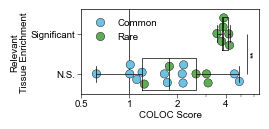

In [244]:
all_ts['test'] = all_ts.Log10PValue > -1 * np.log10(0.05)
from scipy.stats import mannwhitneyu
p = mannwhitneyu(all_ts[all_ts.test].Log2SizeOE.values, all_ts[~all_ts.test].Log2SizeOE.values).pvalue
print(p)
_ = plt.figure(figsize=(2.3,1.1))
ax2 = plt.gca() 
ax2.vlines(x=0, ymin=-0.5, ymax=1.6, color='black', linestyle='-', linewidth=0.5)
sns.swarmplot(all_ts, y='test', x='Log2SizeOE', alpha=1, hue='Group', palette=[blue, green], s=6, edgecolor='black', 
              linewidth=0.3, zorder=2, orient='h')
sns.boxplot(all_ts, y='test', x='Log2SizeOE',fliersize=0,  fill=False, color='black', 
            linewidth=0.5, zorder=3, orient='h')
plt.ylabel('Relevant\nTissue Enrichment')
plt.text(2.6, 0.5, f'**', ha='center', va='center', fontsize=7, rotation=90)
plt.xlim(-1,2.6)

ax2.set_xticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax2.set_xticks(np.log2([3,5,6, 7]), minor=True)
ax2.set_xlabel('COLOC Score')
ax2.set_yticks([1,0], labels = ['Significant', 'N.S.'])
ax2.vlines(x=2.45, ymin=0, ymax=1, color='black', linestyle='-', linewidth=0.5)
plt.xlim(-1,2.7)
ax2.set_ylim(-0.5, 1.6)
#plt.savefig(os.path.join(figdir, 'n_mRNA_by_tiss_spec.svg'), bbox_inches='tight', dpi=300)

### Glucose Measurement

In [245]:
glucose = 'EFO_0004468'

In [246]:
print(f'Glucose measurement COLOC Score: {2*(best_df[best_df.EFO==glucose].Log2SizeOE.values[0]):.2f}')

Glucose measurement COLOC Score: 3.64


In [247]:
bio_df.set_index('EFO').loc[glucose]

,LOEUF,GeneSize,GO,mRNA,nTissues,Set
EFO,,,,,,
EFO_0004468,2.10250,107884.0,20.5,13.610350,53.0,Common
EFO_0004468,0.23182,8709.0,9.0,0.224811,2.0,Rare


In [248]:
glucose_rare_set = pd.read_csv(os.path.join(inputdir, 'March_2025/34226706_EFO_0004468_RV.txt'), sep='\t')

In [260]:
nrnb_dir = '/cellar/users/snwright/Data/RareCommon'
constraint_df = pd.read_csv(os.path.join(nrnb_dir, 'Annotations/Gene_pLI.txt'), sep='\t')

In [261]:
glucose_rare_set.merge(constraint_df, on='Entrez', how='left')

,Entrez,Gene Symbol,Ensembl ID,P-value,lof.pLI,lof.z_score,LOEUF
0,57818,G6PC2,ENSG00000278373,1.400000e-170,3.558400e-05,1.679,-0.17068
1,56172,ANKH,ENSG00000154122,5.200000e-13,9.970600e-01,0.463,4.18910
2,169026,SLC30A8,ENSG00000164756,5.100000e-07,1.261500e-05,0.921,1.76270
3,83795,KCNK16,ENSG00000095981,8.300000e-07,8.718700e-09,1.463,-0.13173
4,84826,SFT2D3,ENSG00000173349,2.100000e-06,2.927500e-01,1.892,0.23182


### Figure 5D

In [264]:
kegg_data = pd.read_csv(os.path.join(datadir, 'outputs/gProfiler_hsapiens_5-19-2025_11-22-48 AM__intersections.csv'), sep=',')
kegg_data['GeneRatio'] = kegg_data['intersection_size']/kegg_data['query_size']
kegg_data['TermRatio'] = kegg_data['intersection_size']/kegg_data['term_size']
# filter the kegg data
kegg_data = kegg_data[(kegg_data['adjusted_p_value'] < 0.05)]
kegg_data = kegg_data[kegg_data['intersection_size'] > 20]
kegg_data = kegg_data[kegg_data['term_size'] < 1000]
kegg_data = kegg_data.sort_values(by='adjusted_p_value', ascending=True).drop_duplicates(subset='term_name')

In [265]:
hp_data = kegg_data[kegg_data.source=='HP']
kegg_data = kegg_data[kegg_data.source=='KEGG']

In [266]:
term_sims = np.zeros((len(kegg_data), len(kegg_data)))
intersection_sets = {}
for i in tqdm(range(len(kegg_data))):
    intersection_sets[i] = set(kegg_data.iloc[i].intersections.split(','))
    term_sims[i, i] = 1
for i in tqdm(range(len(kegg_data))):
    for j in range(i+1, len(kegg_data)):
        term_sims[i, j] = len(intersection_sets[i].intersection(intersection_sets[j]))/len(intersection_sets[i].union(intersection_sets[j]))
        term_sims[j, i] = term_sims[i, j]

100%|██████████| 19/19 [00:00<00:00, 28189.52it/s]


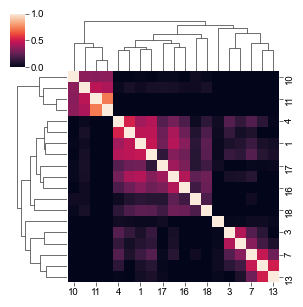

In [267]:
cg = sns.clustermap(term_sims, figsize=(3,3))
plt.savefig(os.path.join(figdir, 'kegg_clustermap.svg'), bbox_inches='tight', dpi=300)
order= cg.dendrogram_row.reordered_ind[4:] + cg.dendrogram_row.reordered_ind[:4]

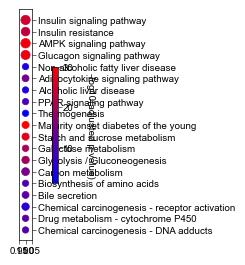

In [268]:
import matplotlib as mpl
_ = plt.figure(figsize=(0.5, 3))
order = order[::-1]
cmap_blended = sns.blend_palette(["blue", 'red'], as_cmap=True)
norm = mpl.colors.Normalize(vmin=-1*np.log10(0.05), vmax=30)
scatter = plt.scatter(
    x=np.ones_like(kegg_data.iloc[order]['term_name']),  # constant x to align vertically
    y=kegg_data.iloc[order]['term_name'],
    c=kegg_data.iloc[order]['negative_log10_of_adjusted_p_value'],
    s=kegg_data.iloc[order]['intersection_size'],  # scale size if needed
    cmap=cmap_blended,
    norm=norm
)
cbar = plt.colorbar(scatter, pad=0.5)
cbar.set_label('-log10(adjusted p-value)', rotation=270, labelpad=15)
plt.gca().yaxis.tick_right()
plt.ylabel("")
plt.savefig(os.path.join(figdir, 'kegg_enrichments.svg'), bbox_inches='tight', dpi=300)

In [269]:
kegg_data[kegg_data.term_name.isin(['AMPK signaling pathway', 'Glucagon signaling pathway', 'Insulin signaling pathway', 'Insulin resistance'])]

,source,term_name,term_id,adjusted_p_value,negative_log10_of_adjusted_p_value,term_size,query_size,intersection_size,effective_domain_size,intersections,GeneRatio,TermRatio
1,KEGG,AMPK signaling pathway,KEGG:04152,3.472801e-29,28.459320,120,386,46,8484,"9370,92579,90993,8789,8660,84699,79602,6720,65...",0.119171,0.383333
2,KEGG,Glucagon signaling pathway,KEGG:04922,2.230667e-28,27.651565,107,386,43,8484,"92579,91860,90993,8789,84699,816,6514,5837,583...",0.111399,0.401869
4,KEGG,Insulin signaling pathway,KEGG:04910,1.505333e-25,24.822368,137,386,45,8484,"92579,91860,90673,89801,8789,8660,80201,79660,...",0.116580,0.328467
5,KEGG,Insulin resistance,KEGG:04931,7.507778e-24,23.124489,108,386,39,8484,"92579,90993,90673,8660,84699,79660,6720,6517,6...",0.101036,0.361111


In [270]:
hp_data = hp_data.sort_values(by='adjusted_p_value', ascending=True)
hp_data = hp_data[hp_data.adjusted_p_value< 5e-5]

In [271]:
term_sims = np.zeros((len(hp_data), len(hp_data)))
intersection_sets = {}
for i in tqdm(range(len(hp_data))):
    intersection_sets[i] = set(hp_data.iloc[i].intersections.split(','))
    term_sims[i, i] = 1
for i in tqdm(range(len(hp_data))):
    for j in range(i+1, len(hp_data)):
        term_sims[i, j] = len(intersection_sets[i].intersection(intersection_sets[j]))/len(intersection_sets[i].union(intersection_sets[j]))
        term_sims[j, i] = term_sims[i, j]

100%|██████████| 19/19 [00:00<00:00, 23247.31it/s]


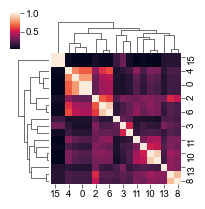

In [272]:
cg2 = sns.clustermap(term_sims, figsize=(2,2))
plt.savefig(os.path.join(figdir, 'hp_clustermap.svg'), bbox_inches='tight', dpi=300)
order= cg2.dendrogram_row.reordered_ind#[4:] + cg.dendrogram_row.reordered_ind[:4]

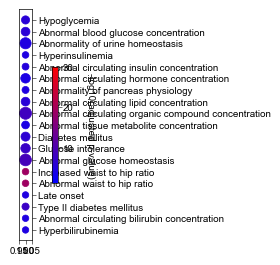

In [273]:
import matplotlib as mpl
_ = plt.figure(figsize=(0.5, 3))
cmap_blended = sns.blend_palette(["blue", 'red'], as_cmap=True)
norm = mpl.colors.Normalize(vmin=-1*np.log10(0.05), vmax=30)
scatter = plt.scatter(
    x=np.ones_like(hp_data.iloc[order]['term_name']),  # constant x to align vertically
    y=hp_data.iloc[order]['term_name'],
    c=hp_data.iloc[order]['negative_log10_of_adjusted_p_value'],
    s=hp_data.iloc[order]['intersection_size'],  # scale size if needed
    cmap=cmap_blended,
    norm=norm
)
cbar = plt.colorbar(scatter, pad=0.5)
cbar.set_label('-log10(adjusted p-value)', rotation=270, labelpad=15)
plt.gca().yaxis.tick_right()
plt.ylabel("")
plt.savefig(os.path.join(figdir, 'hp_enrichments.svg'), bbox_inches='tight', dpi=300)

In [274]:
hp_data[hp_data.term_name.isin(['Increased waist to hip ratio', 'Type II diabetes mellitus'])]

,source,term_name,term_id,adjusted_p_value,negative_log10_of_adjusted_p_value,term_size,query_size,intersection_size,effective_domain_size,intersections,GeneRatio,TermRatio
291,HP,Increased waist to hip ratio,HP:0031819,7.517890e-20,19.123904,35,235,23,5080,"8660,8431,7466,7352,6934,6928,6927,6833,6514,5...",0.097872,0.657143
311,HP,Type II diabetes mellitus,HP:0005978,1.374913e-08,7.861725,137,235,27,5080,"8660,8462,7466,6934,6928,6927,6833,6690,6514,6...",0.114894,0.197080


In [334]:
npd_df.sort_values(by='P_size', ascending=True).loc[:, ['name', 'P_size', 'log2COLOC']].head(3)

,name,P_size,log2SizeOE
161,autism spectrum disorder,2.740000e-266,1.494694
191,Alzheimer disease,2.162000e-87,1.119217
197,bipolar disorder,1.940000e-58,1.042778
